# Instalando dependencias

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime
!pip install folderstats
!pip install labelme2coco
!pip install labelme

# Importamos librerias y creamos dataset

importación de las librerías necesarias.

In [ ]:
import detectron2

# import some common libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import zipfile

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

from detectron2.utils.logger import setup_logger
setup_logger()
import torch, torchvision
print(torch.__version__, torch.cuda.is_available(), torchvision.__version__)
!gcc --version

## Test CUDA OK

In [ ]:
import torch, torchvision
print(torch.rand(1, device="cpu"))
print(torch.rand(1, device="cuda"))

## Creación del dataset con las rutas de imagen y json asociados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


OBTENEMOS UN DATA SET CON LA SIGUIENTE ESTRUCTURA (IMÁGENES Y JSON CON ETIQUETAS Y BOUNDING BOX): 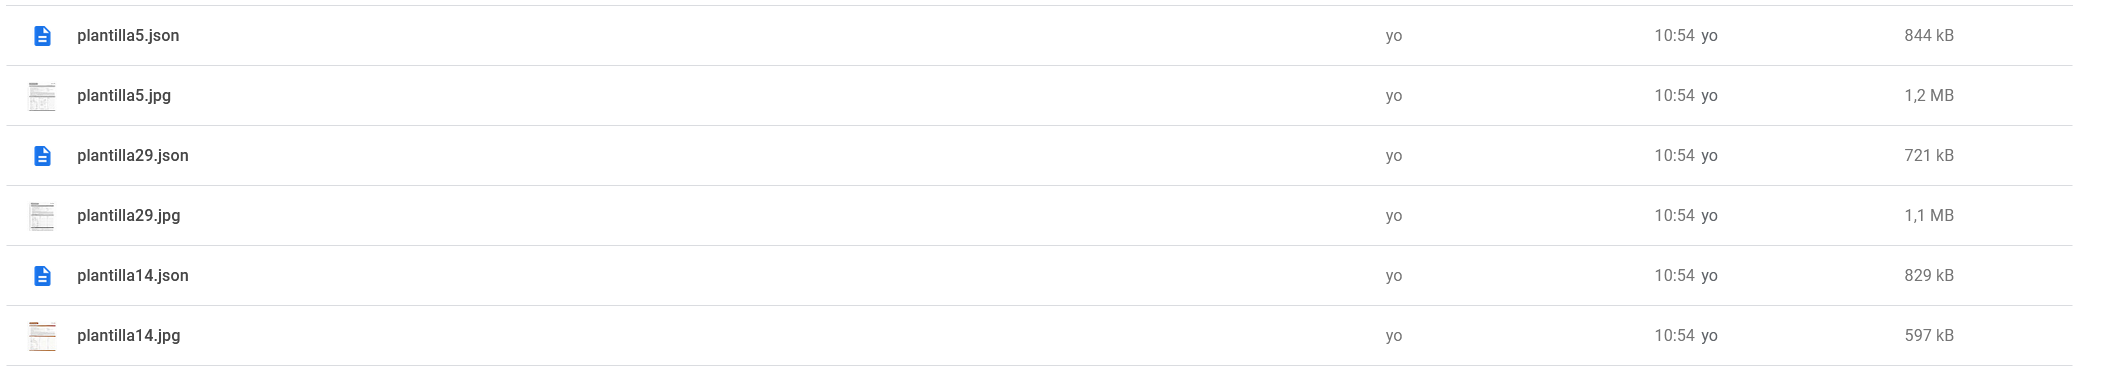

## Split en Train y Test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1)

print(train.shape)
print(test.shape)

train.to_excel('/content/drive/MyDrive/Campo/identificacion_naranjas/data/train_set.xlsx',index=False)
test.to_excel('/content/drive/MyDrive/Campo/identificacion_naranjas/data/test_set.xlsx',index=False)

(11, 2)
(2, 2)


In [ ]:
import os
import shutil

folders=[('train', train), ('test',test)]
dir_path='/content/drive/MyDrive/Campo/identificacion_naranjas/data'

for f in folders:
    new_path=os.path.join(dir_path, f[0])   
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for _, row in f[1].iterrows():
        shutil.move(str(row['path']) , new_path)
        shutil.move(str(row['json']) , new_path)

## labelme2coco

In [ ]:
import labelme2coco
# set directory that contains labelme annotations and image files
labelme_folder = '/content/drive/MyDrive/Campo/identificacion_naranjas/data/dataset'
# set export dir
export_dir = '/content/drive/MyDrive/Campo/identificacion_naranjas/data/'

# set train split rate
train_split_rate = 0.9

# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, export_dir,train_split_rate)

There are 13 listed files in folder dataset.


Converting labelme annotations to COCO format: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s]
02/19/2022 15:01:40 - INFO - labelme2coco -   Training split in COCO format is exported to /content/drive/MyDrive/Campo/identificacion_naranjas/data/train.json
02/19/2022 15:01:40 - INFO - labelme2coco -   Validation split in COCO format is exported to /content/drive/MyDrive/Campo/identificacion_naranjas/data/val.json


## Registrar datasets

In [ ]:
from detectron2.data.datasets import register_coco_instances


# for d in ["train", "test"]:
register_coco_instances(f"dataset_naranja_train", {}, f'/content/drive/MyDrive/Campo/identificacion_naranjas/data/train.json', f"/content/drive/MyDrive/Campo/identificacion_naranjas/data/dataset")
register_coco_instances(f"dataset_naranja_test", {}, f'/content/drive/MyDrive/Campo/identificacion_naranjas/data/val.json', f"/content/drive/MyDrive/Campo/identificacion_naranjas/data/dataset")

In [ ]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
import matplotlib.pyplot as plt
import cv2
dataset_dicts = DatasetCatalog.get("dataset_naranja_train")
metadata = MetadataCatalog.get("dataset_naranja_train")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    # print("imagen",img)
    print(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata= metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (25, 20))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Entrenamiento *

In [ ]:
OUTPUT_DIR="/content/drive/MyDrive/Campo/identificacion_naranjas/data/model_output"

In [ ]:
#Antes de entrenar tenemos que asegurar que el modelo valida contra el dataset de Val, por defecto detectron2 no lo hace, por ello se define
#un custom trainer con COCO Evaluator
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("/content/drive/MyDrive/Campo/identificacion_naranjas/data/eval", exist_ok=True)
        output_folder = "/content/drive/MyDrive/Campo/identificacion_naranjas/data/eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

cfg = get_cfg()
cfg.OUTPUT_DIR=OUTPUT_DIR
os.makedirs(OUTPUT_DIR, exist_ok=True)
#se elige el yaml de configuración deseado, ver tabla COCO Instance Segmentation Baselines with Mask R-CNN en 
#https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_naranja_train",)
cfg.DATASETS.TEST = ("dataset_naranja_test",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 20000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 100
cfg.TEST.EVAL_PERIOD = 1000
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/20 12:01:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[02/20 12:01:49 d2.utils.events]:  eta: 2:06:00  iter: 10019  total_loss: 0.6107  loss_cls: 0.09632  loss_box_reg: 0.343  loss_rpn_cls: 0.03678  loss_rpn_loc: 0.1576  time: 0.7497  data_time: 0.1963  lr: 0.00025  max_mem: 1944M
[02/20 12:02:05 d2.utils.events]:  eta: 2:09:14  iter: 10039  total_loss: 0.6197  loss_cls: 0.09908  loss_box_reg: 0.3586  loss_rpn_cls: 0.03701  loss_rpn_loc: 0.1546  time: 0.7663  data_time: 0.1526  lr: 0.00025  max_mem: 1944M
[02/20 12:02:20 d2.utils.events]:  eta: 2:09:44  iter: 10059  total_loss: 0.6576  loss_cls: 0.1043  loss_box_reg: 0.3753  loss_rpn_cls: 0.02714  loss_rpn_loc: 0.1666  time: 0.7704  data_time: 0.1441  lr: 0.00025  max_mem: 2076M
[02/20 12:02:35 d2.utils.events]:  eta: 2:08:43  iter: 10079  total_loss: 0.6376  loss_cls: 0.09915  loss_box_reg: 0.3384  loss_rpn_cls: 0.03291  loss_rpn_loc: 0.1514  time: 0.7654  data_time: 0.1594  lr: 0.00025  max_mem: 2076M
[02/20 12:02:50 d2.utils.events]:  eta: 2:05:45  iter: 10099  total_loss: 0.666  loss_

# INFERENCIA DE IMAGENES

In [ ]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
from PIL import Image
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
import random
dataset_dicts = DatasetCatalog.get("dataset_naranja_test")
metadata = MetadataCatalog.get("dataset_naranja_test")
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(25,20))
    plt.imshow(v.get_image())
    # plt.savefig('prueba.jpg')
    v.save('prueba.jpg') 

Output hidden; open in https://colab.research.google.com to view.